In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

**RATINGS FILE DESCRIPTION**<br/>
<br/>
All ratings are contained in the file "ratings.dat" and are in the following format:<br/>
<br/>
UserID::MovieID::Rating::Timestamp<br/>

- UserIDs range between 1 and 6040
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [2]:
data_path = Path(os.getenv('HOME') + '/aiffel/yoochoose/data/')

def load_data(path : Path):
    data = pd.read_csv(path, sep = '::', usecols = [0, 1, 2, 3], dtype = {0: np.int32, 1:np.int32, 2:np.int32}, engine = 'python')
    data.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit = 's')
    data.sort_values(['UserID', 'Timestamp'], inplace = True)
    return data

data = load_data(data_path / 'ratings.dat')
data

,UserID,MovieID,Rating,Timestamp
30,1,3186,4,2000-12-31 22:00:19
21,1,1270,5,2000-12-31 22:00:55
26,1,1721,4,2000-12-31 22:00:55
36,1,1022,5,2000-12-31 22:00:55
23,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000018,6040,2917,4,2001-08-10 14:40:29
999987,6040,1921,4,2001-08-10 14:41:04
1000171,6040,1784,3,2001-08-10 14:41:04
1000166,6040,161,3,2001-08-10 14:41:26


In [3]:
data['UserID'].nunique(), data['MovieID'].nunique() # user와 movie의 수

(6040, 3706)

---

**세션 단위 길이 분석**

In [4]:
data_by_user = data.groupby('UserID').size() # user 1명당 row 수
data_by_user.describe()

count    6040.000000
mean      165.597351
std       192.747126
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [5]:
data_by_user.quantile(0.999) # user 99.9%의 row 수 

1343.181000000005

In [6]:
data_by_user[data_by_user > 1500] # row가 1500 이상인 user

UserID
889     1518
1181    1521
1680    1850
1941    1595
4169    2314
4277    1743
dtype: int64

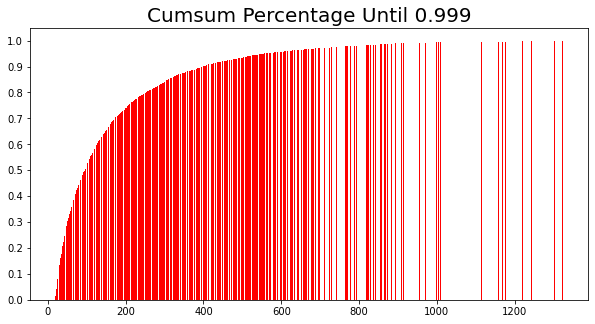

In [7]:
# 누적 차트
def draw_cumsum(data_length = data_by_user):
    length_count = data_length.groupby(data_length).size()
    length_percent_cumsum = length_count.cumsum() / length_count.sum()
    length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]
    
    plt.figure(figsize = (10, 5))
    plt.bar(x = length_percent_cumsum_999.index,
            height = length_percent_cumsum_999, color = 'red')
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.title('Cumsum Percentage Until 0.999', size = 20)
    plt.show()

draw_cumsum(data_by_user)

* 영화 산업 특성상 로그인할 때마다 원하는 영화가 크게 바뀌지 않을 것이라고 판단 세션은 user 단위 그대로 하기로 함
* 리뷰의 개수가 최대 2314개인 것을 보고 오류 혹은 의도적인 리뷰 조작이라고 생각되었으나 1500개 이상의 리뷰를 등록한 사용자가 너무 많으며 영화 종류가 다양하고 rating을 골고루 평가한 것을 보고 별다른 조치를 취하지 않기로 함

---

**세션 단위 시간 분석**

In [8]:
data['Timestamp'].min(), data['Timestamp'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [9]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserID').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserID'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('MovieID').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['MovieID'].isin(item_use)]
    return data

In [10]:
data = cleanse_recursive(data, shortest = 2, least_click = 5)
data

,UserID,MovieID,Rating,Timestamp
30,1,3186,4,2000-12-31 22:00:19
21,1,1270,5,2000-12-31 22:00:55
26,1,1721,4,2000-12-31 22:00:55
36,1,1022,5,2000-12-31 22:00:55
23,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000018,6040,2917,4,2001-08-10 14:40:29
999987,6040,1921,4,2001-08-10 14:41:04
1000171,6040,1784,3,2001-08-10 14:41:04
1000166,6040,161,3,2001-08-10 14:41:26


In [11]:
d = data['Timestamp'].max() - dt.timedelta(100)
data100 = data[data['Timestamp'] > d]
data100 = cleanse_recursive(data100, shortest = 2, least_click = 5)
data100

,UserID,MovieID,Rating,Timestamp
5363,36,3786,4,2002-12-22 08:08:41
5261,36,2369,4,2002-12-22 08:09:24
5279,36,3174,4,2002-12-22 08:11:25
5221,36,296,5,2002-12-22 08:16:59
5103,36,247,4,2002-12-22 08:17:48
...,...,...,...,...
984730,5950,3948,4,2003-02-27 18:13:57
984681,5950,3578,4,2003-02-27 18:14:30
984474,5950,3793,3,2003-02-27 18:15:10
984659,5950,3555,2,2003-02-27 18:15:37


* 최근 100일 데이터를 사용하는 것을 고려했으나 너무 적은 데이터량(1,948)으로 원본 3년치 데이터(999,610)를 그대로 사용

In [12]:
def split_by_date(data: pd.DataFrame, n_days: int):
    latest = data['Timestamp'].max()
    train = data[data['Timestamp'] < latest - dt.timedelta(n_days)]
    test = data[data['Timestamp'] >= latest - dt.timedelta(n_days)]

    return train, test

train, test = split_by_date(data, n_days = 30)
train, valid = split_by_date(train, n_days = 30)

In [13]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserID"].nunique()}\n'
          f'\t Items: {data["MovieID"].nunique()}\n'
          f'\t First Time : {data["Timestamp"].min()}\n'
          f'\t Last Time : {data["Timestamp"].max()}\n')
    
stats_info(train, 'TRAIN')
stats_info(valid, 'VALID')
stats_info(test, 'TEST')

* TRAIN Set Stats Info
	 Events: 996232
	 Sessions: 6040
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-12-30 16:54:04

* VALID Set Stats Info
	 Events: 1827
	 Sessions: 135
	 Items: 1155
	 First Time : 2002-12-30 18:21:02
	 Last Time : 2003-01-29 17:00:13

* TEST Set Stats Info
	 Events: 1551
	 Sessions: 103
	 Items: 1008
	 First Time : 2003-01-29 19:36:56
	 Last Time : 2003-02-28 17:49:50



---

**Data Pipeline**

In [14]:
id2idx = {item_id : idx for idx, item_id in enumerate(train['MovieID'].unique())}

def indexing(data, id2idx):
    data['MovieIDX'] = data['MovieID'].map(lambda x : id2idx.get(x, -1))
    return data

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

/tmp/ipykernel_13/780859563.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MovieIDX'] = data['MovieID'].map(lambda x : id2idx.get(x, -1))


In [15]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [16]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserID'].nunique())

    def get_click_offsets(self):
        offsets = np.zeros(self.df['UserID'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserID').size().cumsum()
        return offsets
    
    
train_dataset = SessionDataset(train)

In [17]:
train_dataset.df.head(10)

,UserID,MovieID,Rating,Timestamp,MovieIDX
30,1,3186,4,2000-12-31 22:00:19,0
21,1,1270,5,2000-12-31 22:00:55,1
26,1,1721,4,2000-12-31 22:00:55,2
36,1,1022,5,2000-12-31 22:00:55,3
23,1,2340,3,2000-12-31 22:01:43,4
35,1,1836,5,2000-12-31 22:02:52,5
2,1,3408,4,2000-12-31 22:04:35,6
6,1,2804,5,2000-12-31 22:11:59,7
46,1,1207,4,2000-12-31 22:11:59,8
20,1,720,3,2000-12-31 22:12:40,9


In [18]:
train_dataset.click_offsets

array([     0,     52,    181, ..., 995768, 995891, 996232], dtype=int32)

In [19]:
train_dataset.user_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [20]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1
            for i in range(min_len):
                inp = self.dataset.df['MovieIDX'].values[start + i]
                target = self.dataset.df['MovieIDX'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)
        last_session = self.batch_size - 1
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]
        mask = np.array([])
        finished = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):
        start += min_len
        mask = np.arange(self.batch_size)[(end - start) == 1]

        for i, idx in enumerate(mask, start=1):
            new_session = last_session + i
            if new_session > self.dataset.user_idx[-1]:
                finished = True
                break

            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_session]]
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_session] + 1]

        last_session += len(mask)
        return start, end, mask, last_session, finished

    
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)

In [21]:
iter_ex = iter(train_data_loader)
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 52 65 53]
Label Item Idx are :       [ 1 53 62 23]
Previous Masked Input Idx are []


---

**모델링**

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [23]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [24]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['MovieID'].nunique()
        self.num_sessions = tr['UserID'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      520200    
_________________________________________________________________
dropout (Dropout)            (16, 50)                  0         
_________________________________________________________________
dense (Dense)                (16, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [25]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserID'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserID'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [54]:
# batch size 16, drop rate 0.1, learning rate = 0.001, epochs 3
train_model(model, args)

Evaluation:  49%|████▊     | 51/105 [00:05<00:05,  9.63it/s]


	 - Recall@20 epoch 1: 0.134804
	 - MRR@20    epoch 1: 0.044028



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 10.86it/s]


	 - Recall@20 epoch 2: 0.128676
	 - MRR@20    epoch 2: 0.047809



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 10.94it/s]

	 - Recall@20 epoch 3: 0.142157
	 - MRR@20    epoch 3: 0.046814



In [55]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  34%|███▍      | 31/90 [00:02<00:05, 10.87it/s]

	 - Recall@20: 0.127016
	 - MRR@20: 0.047084



In [27]:
# batch size 8, drop rate 0.1, learning rate = 0.01, epochs 10
args = Args(train, valid, test, batch_size=8, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(8, 1, 3416)]            0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        520200    
_________________________________________________________________
dropout_2 (Dropout)          (8, 50)                   0         
_________________________________________________________________
dense_2 (Dense)              (8, 3416)                 174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.07it/s]


	 - Recall@20 epoch 1: 0.093496
	 - MRR@20    epoch 1: 0.022322



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.03it/s]


	 - Recall@20 epoch 2: 0.090447
	 - MRR@20    epoch 2: 0.021470



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.54it/s]


	 - Recall@20 epoch 3: 0.096545
	 - MRR@20    epoch 3: 0.027304



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.64it/s]


	 - Recall@20 epoch 4: 0.099593
	 - MRR@20    epoch 4: 0.029080



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.70it/s]


	 - Recall@20 epoch 5: 0.089431
	 - MRR@20    epoch 5: 0.027131



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.43it/s]


	 - Recall@20 epoch 6: 0.088415
	 - MRR@20    epoch 6: 0.026774



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 15.91it/s]


	 - Recall@20 epoch 7: 0.078252
	 - MRR@20    epoch 7: 0.014405



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.31it/s]


	 - Recall@20 epoch 8: 0.068089
	 - MRR@20    epoch 8: 0.016448



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.56it/s]


	 - Recall@20 epoch 9: 0.095528
	 - MRR@20    epoch 9: 0.023063



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.65it/s]


	 - Recall@20 epoch 10: 0.079268
	 - MRR@20    epoch 10: 0.021264



Evaluation:  70%|██████▉   | 126/181 [00:07<00:03, 16.55it/s]

	 - Recall@20: 0.104167
	 - MRR@20: 0.024068



In [28]:
# batch size 8, drop rate 0.5, learning rate = 0.01, epochs 10
args = Args(train, valid, test, batch_size=8, hsz=50, drop_rate=0.5, lr=0.01, epochs=10, k=20)
model = create_model(args)
train_model(model, args)
test_model(model, args, test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(8, 1, 3416)]            0         
_________________________________________________________________
GRU (GRU)                    [(8, 50), (8, 50)]        520200    
_________________________________________________________________
dropout_3 (Dropout)          (8, 50)                   0         
_________________________________________________________________
dense_3 (Dense)              (8, 3416)                 174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 15.98it/s]


	 - Recall@20 epoch 1: 0.073171
	 - MRR@20    epoch 1: 0.015656



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.44it/s]


	 - Recall@20 epoch 2: 0.070122
	 - MRR@20    epoch 2: 0.015506



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.40it/s]


	 - Recall@20 epoch 3: 0.068089
	 - MRR@20    epoch 3: 0.015087



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.34it/s]


	 - Recall@20 epoch 4: 0.077236
	 - MRR@20    epoch 4: 0.016242



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 15.95it/s]


	 - Recall@20 epoch 5: 0.067073
	 - MRR@20    epoch 5: 0.019314



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.64it/s]


	 - Recall@20 epoch 6: 0.068089
	 - MRR@20    epoch 6: 0.018665



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.50it/s]


	 - Recall@20 epoch 7: 0.064024
	 - MRR@20    epoch 7: 0.013691



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.22it/s]


	 - Recall@20 epoch 8: 0.070122
	 - MRR@20    epoch 8: 0.014953



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 16.30it/s]


	 - Recall@20 epoch 9: 0.066057
	 - MRR@20    epoch 9: 0.015063



Evaluation:  58%|█████▊    | 123/211 [00:07<00:05, 15.62it/s]


	 - Recall@20 epoch 10: 0.064024
	 - MRR@20    epoch 10: 0.012974



Evaluation:  70%|██████▉   | 126/181 [00:07<00:03, 16.48it/s]

	 - Recall@20: 0.070437
	 - MRR@20: 0.013501



In [29]:
# batch size 16, drop rate 0.1, learning rate = 0.001, epochs 10

args = Args(train, valid, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model = create_model(args)
train_model(model, args)

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(16, 1, 3416)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      520200    
_________________________________________________________________
dropout_4 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_4 (Dense)              (16, 3416)                174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.44it/s]


	 - Recall@20 epoch 1: 0.131127
	 - MRR@20    epoch 1: 0.045178



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 11.18it/s]


	 - Recall@20 epoch 2: 0.143382
	 - MRR@20    epoch 2: 0.051635



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 11.10it/s]


	 - Recall@20 epoch 3: 0.143382
	 - MRR@20    epoch 3: 0.051728



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 11.04it/s]


	 - Recall@20 epoch 4: 0.151961
	 - MRR@20    epoch 4: 0.054041



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 11.22it/s]


	 - Recall@20 epoch 5: 0.155637
	 - MRR@20    epoch 5: 0.050984



Evaluation:  49%|████▊     | 51/105 [00:04<00:05, 10.65it/s]


	 - Recall@20 epoch 6: 0.154412
	 - MRR@20    epoch 6: 0.050238



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 10.94it/s]


	 - Recall@20 epoch 7: 0.164216
	 - MRR@20    epoch 7: 0.052172



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 11.11it/s]


	 - Recall@20 epoch 8: 0.143382
	 - MRR@20    epoch 8: 0.052331



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 10.96it/s]


	 - Recall@20 epoch 9: 0.140931
	 - MRR@20    epoch 9: 0.052809



Evaluation:  49%|████▊     | 51/105 [00:04<00:04, 11.15it/s]


	 - Recall@20 epoch 10: 0.149510
	 - MRR@20    epoch 10: 0.054075



Evaluation:  34%|███▍      | 31/90 [00:02<00:05, 11.30it/s]

	 - Recall@20: 0.143145
	 - MRR@20: 0.050426



---

**프로젝트 평가**

|항목|batch size|drop rate|learning rate|epoch|**Recall**|**MRR**|
|:------:|:---:|:---:|:---:|:---:|:---:|:---:|
|테스트 1|16|0.1|0.001|3|0.127|0.047|
|테스트 2|8|0.1|0.01|10|0.104|0.024|
|테스트 3|8|0.5|0.01|10|0.070|0.014|
|테스트 4|16|0.1|0.001|10|0.143|0.050|

* batch size, drop rate, learning rate, epochs의 변화를 시도했지만 초기에서 epochs만 바꿨을 때만 효과가 좋았다.
* learning rate를 키웠을 때 loss가 크게 요동치는 경우 learning rate를 줄이는 방안을,
* learning rate를 줄였을 때 loss에 거의 변화가 없는 경우 learning rate를 키우는 방안을 선택하는데 이도저도 아니었다.
* drop rate의 효과가 궁금해서 이를 줄여보고 싶었는데 시간이 부족하여 하지 못했다. drop rate를 키웠을 때는 결과가 악화되었다.
* Test 결과로 봤을 때, 테스트 4 케이스에서 가장 성과가 좋고 테스트 3 케이스에서 가장 성과가 좋지 않다.

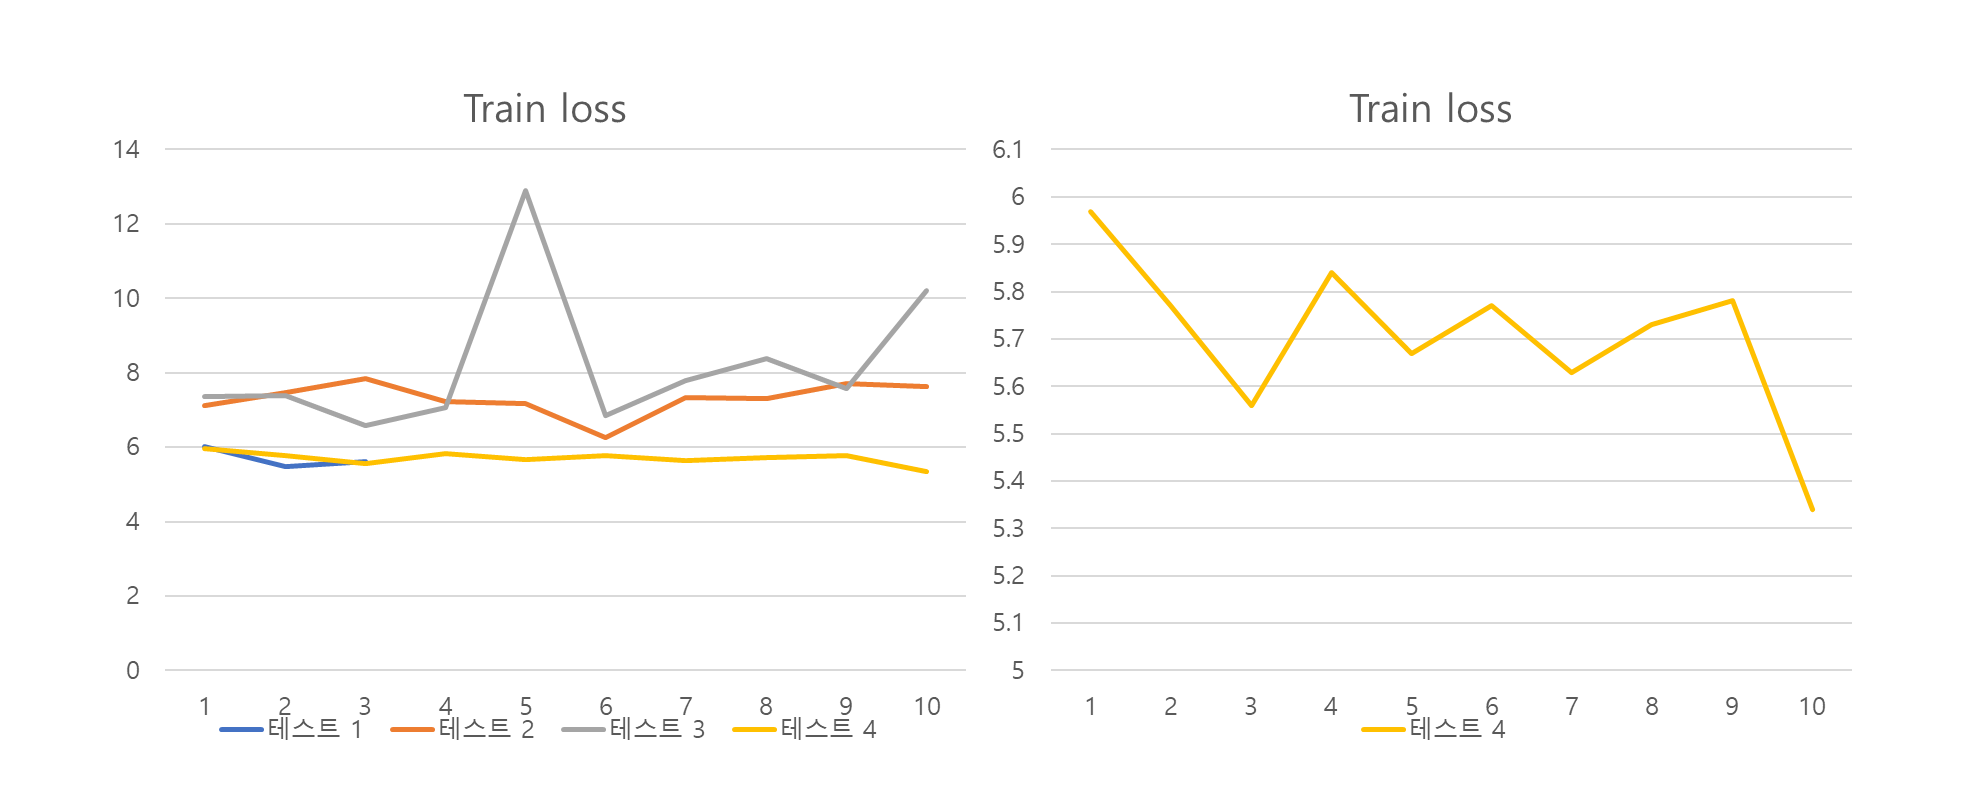

* epochs는 최대 10회로 설정했는데 이 구간에서는 epochs을 늘리는 것이 성과에 좋은 영향이 아니다.
* 가장 성과가 좋았던 테스트 4의 경우 train loss가 지속적으로 감소한다.